<h1 align="center">Forward Diffusion Process</h1> 

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from helper import ForwardDiffusionProcessor, download_images, normalize_image, denormalize_image

/home/chris/miniconda3/envs/stable-diffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


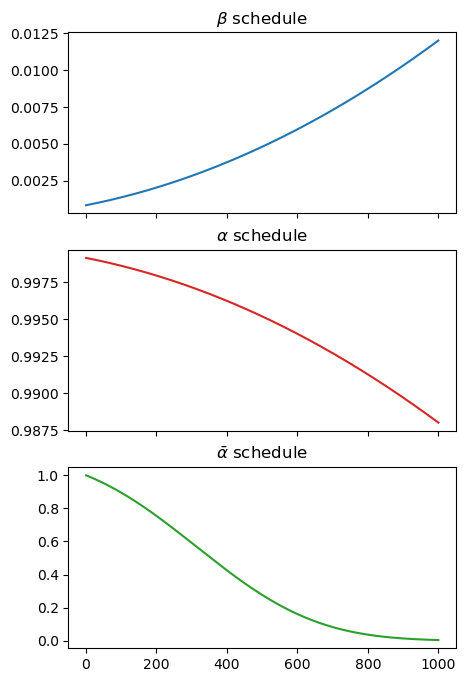

In [3]:
fdp = ForwardDiffusionProcessor()
fig = fdp.plot_schedule()
plt.show()

In [4]:
# Download a random image
res = 256
image = download_images(1, res)[0]
x = normalize_image(image)

# Run diffusion
X = [x]
for step in tqdm(fdp.total_timesteps):
    x_prev = x
    x,  _ = fdp.single_forward_diffusion_step(x_prev, step)
    X.append(x)

100%|██████████| 1000/1000 [00:04<00:00, 241.98it/s]


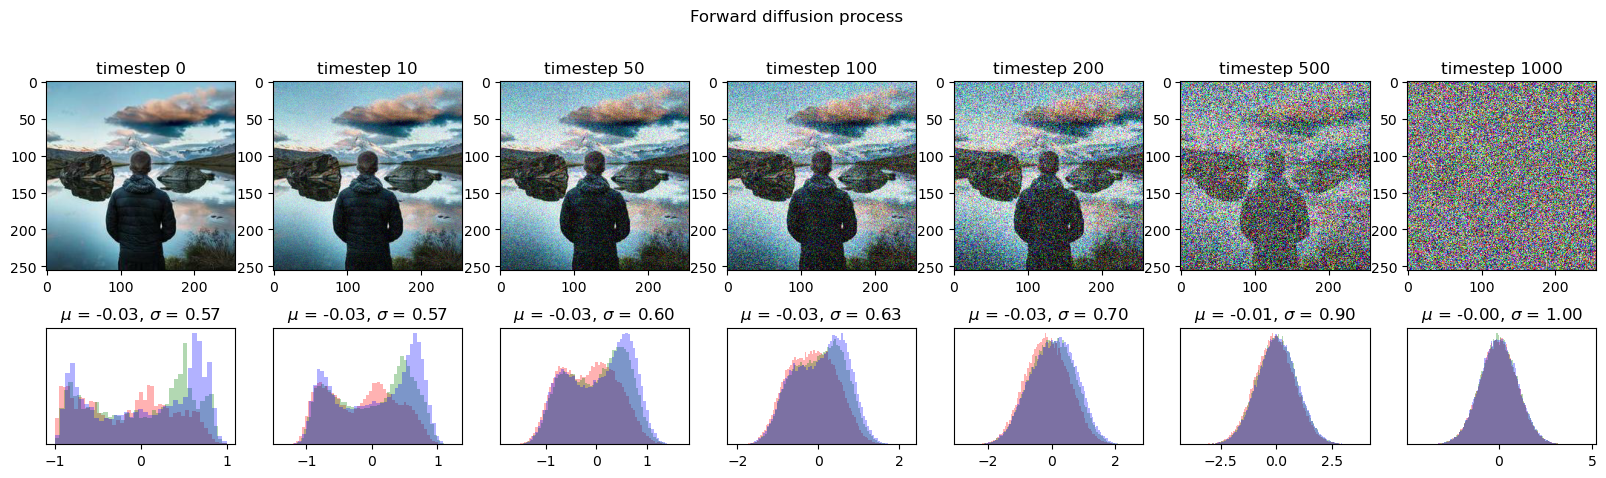

In [5]:
# Plot example images
ts_plot = [0, 10, 50, 100, 200, 500, 1000]

fig, axs = plt.subplots(2, len(ts_plot), figsize=(20, 5), gridspec_kw={"height_ratios": [2, 1]})
for i, ts in enumerate(ts_plot):

    x = X[ts]
    image = denormalize_image(x)

    axs[0, i].imshow(image)
    axs[0, i].set_title(f"timestep {ts}")
    
    for c, color in enumerate(["red", "green", "blue"]):
        sns.histplot(x[:,:,c].flatten(), color=color, alpha=0.3, ax=axs[1, i], linewidth=0)
    axs[1, i].set_yticks([])
    axs[1, i].set_ylabel("")
    axs[1, i].set_title(f"$\mu$ = {x.mean():.2f}, $\sigma$ = {x.std():.2f}")

plt.suptitle("Forward diffusion process")
plt.show()

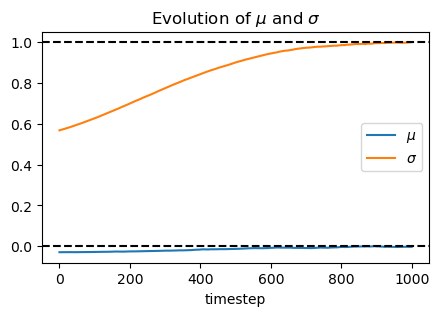

In [6]:
# Plot the evolution of the mean and std
plt.figure(figsize=(5, 3))
plt.plot([x.mean() for x in X], label="$\mu$")
plt.plot([x.std() for x in X], label="$\sigma$")
plt.axhline(0, color="black", linestyle="--")
plt.axhline(1, color="black", linestyle="--")
plt.xlabel("timestep")
plt.title("Evolution of $\mu$ and $\sigma$")
plt.legend()
plt.show()

## Speeding up the diffusion process

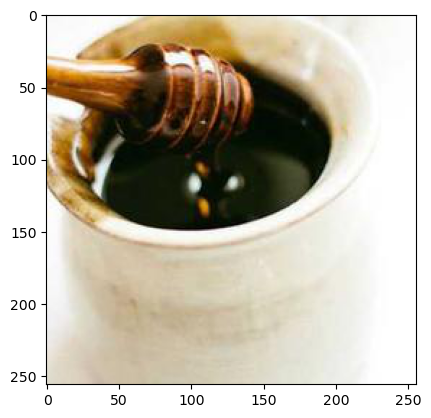

In [7]:
res = 256
image = download_images(1, res)[0]
plt.imshow(image)
plt.show()

100%|██████████| 200/200 [00:00<00:00, 258.41it/s]


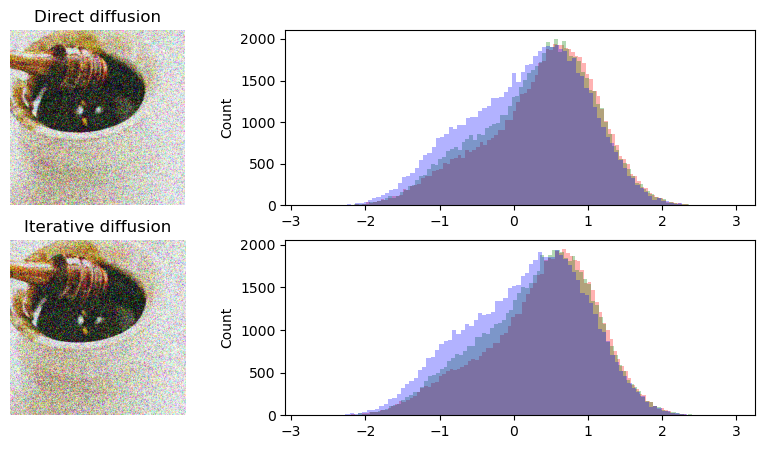

In [8]:
x0 = normalize_image(image)
t = 200 

# go directly to desired step 
xt = fdp.defuse_sample(x0, t)

# run diffusion iterativly
xt_iterative = x0
for step in tqdm(range(t)):
    xt_iterative,  _ = fdp.single_forward_diffusion_step(xt_iterative, step)
    
# plot histpgrams
fig, axs = plt.subplots(2,2, figsize=(10, 5), sharex=False, gridspec_kw={"width_ratios": [1, 2]})

axs[0,0].imshow(denormalize_image(xt))
axs[0,0].axis("off")
axs[0,0].set_title("Direct diffusion")

axs[1,0].imshow(denormalize_image(xt_iterative))
axs[1,0].axis("off")
axs[1,0].set_title("Iterative diffusion")

for c, color in enumerate(["red", "green", "blue"]):
    sns.histplot(xt[:,:,c].flatten(), color=color, alpha=0.3, ax=axs[0,1], linewidth=0)
    sns.histplot(xt_iterative[:,:,c].flatten(), color=color, alpha=0.3, ax=axs[1,1], linewidth=0)

xmin = min(xt.min(), xt_iterative.min())
xmax = max(xt.max(), xt_iterative.max())
axs[0,1].set_xlim(xmin, xmax)
axs[1,1].set_xlim(xmin, xmax)

plt.show()
